In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm

from PIL import Image, ImageOps

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T

import torchvision.transforms.functional as TF
import torchvision.models as models

import albumentations as A
from albumentations.pytorch import ToTensorV2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, "xray_images")

In [4]:
def get_original_position(original_image_size, bbox, bbox_image_size=256):
    """
    from transformed boundary to original image boundary
    :param original_image_size: [h, w]
    :param bbox: [xmin, ymin, xmax, ymax]
    :param bbox_image_size:
    :return:
    """
    h, w = original_image_size
    scale = max(h, w) / bbox_image_size
    org_bbox = bbox * scale

    # print(h, w)
    if h > w:
        pad = (h - w) // 2
        org_bbox[[0, 2]] -= pad
    else:
        pad = (w - h) // 2
        org_bbox[[1, 3]] -= pad
    return org_bbox

get_original_position([620, 512], np.array([100, 80, 200, 200]))

array([188.1875, 193.75  , 430.375 , 484.375 ])

In [5]:
def get_model():
    model = models.efficientnet_v2_m(pretrained=False)
    conv1_weight = model.features[0][0].weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.features[0][0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.features[0][0].weight = nn.Parameter(conv1_weight, requires_grad=True)

    model.avgpool = nn.Sequential(
        nn.MaxPool2d(2, 2),
        nn.Flatten()
    )
    # model.classifier[1] = nn.Linear(1280, 4, bias=True)
    model.classifier[1] = nn.Sequential(
        nn.Linear(81920, 1024, bias=True),
        nn.ReLU(),
        nn.Linear(1024, 4, bias=True)
    )

    return model

model = get_model()
state = torch.load(os.path.join(DATA_DIR, 'checkpoint', 'coronal_effnet-m_boundary_185858-epoch-300.pth'))
model.load_state_dict(state["model"])
model = model.to(device)

/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
xray_images_dir = glob.glob(os.path.join(DATA_DIR, 'xray_images') + '/**')
len(xray_images_dir)

2012

1.2.826.0.1.3680043.10051
512 669


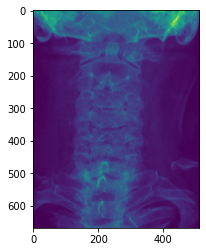

In [7]:
class CoronalBoundaryDataset(Dataset):
    def __init__(self, dirs, transform=None):
        super().__init__()

        self.dirs = dirs
        self.transform = transform

    def __len__(self):
        return len(self.dirs)

    def __getitem__(self, idx):
        image_dir = self.dirs[idx]
        UID = image_dir.split("/")[-1]
        img = Image.open(os.path.join(image_dir, "coronal.jpeg"))
        h, w = img.height, img.width
        if self.transform:
            img = self.transform(img)

        return img, UID, np.array([h, w])

dataset = CoronalBoundaryDataset(xray_images_dir)
img, UID, org_img_size = dataset[6]
print(UID)
print(img.width, img.height)
plt.imshow(img)



1.2.826.0.1.3680043.10041
tensor(-1.) tensor(0.8824)


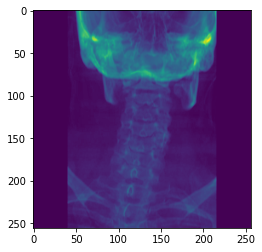

In [8]:
class DataTransform(nn.Module):
    def __init__(self, image_size):
        super().__init__()

        self.transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])

    def forward(self, x):
        x = TF.center_crop(x, max(x.width, x.height))
        x = self.transform(x)

        return x

IMAGE_SIZE = 256
transform = DataTransform(IMAGE_SIZE)
dataset = CoronalBoundaryDataset(xray_images_dir, transform)
img, UID, org_img_size = dataset[5]
print(UID)
# print(img.width, img.height)
print(img.min(), img.max())
plt.imshow(img.squeeze())

In [9]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=min(os.cpu_count(), 16))

In [10]:
UIDs = []
original_image_sizes = []
original_image_positions = []

with torch.no_grad():
    model.eval()

    tqdm_iter = tqdm(dataloader)
    for (x, UID, org_img_size) in tqdm_iter:
        x = x.to(device)
        logits = model(x)
        locs = logits.sigmoid() * IMAGE_SIZE
        locs = locs.cpu().numpy()
        org_img_size = org_img_size.numpy()

        image_positions = []
        for i in range(x.shape[0]):
            original_image_position = get_original_position(org_img_size[i], locs[i], IMAGE_SIZE)
            image_positions.append(original_image_position)

        UIDs.extend(UID)
        original_image_sizes.extend(org_img_size)
        original_image_positions.extend(image_positions)


100%|██████████| 126/126 [00:17<00:00,  7.06it/s]


In [11]:
len(UIDs)

2012

In [12]:
original_image_sizes = np.asarray(original_image_sizes)
original_image_positions = np.asarray(original_image_positions)
len(original_image_positions)

2012

In [13]:
original_image_positions[:4]

array([[ 78.84918 ,  67.13144 , 453.30298 , 628.8439  ],
       [ 93.98891 ,   9.36849 , 373.98172 , 409.21265 ],
       [ 22.234573, 118.48294 , 500.32007 , 843.8693  ],
       [ 73.564575,  46.92755 , 444.91382 , 612.70056 ]], dtype=float32)

In [14]:
df = pd.DataFrame({
    'UID' : UIDs,
    'height' : original_image_sizes[:, 0],
    'width' : original_image_sizes[:, 1],
    'xmin' : original_image_positions[:, 0],
    'ymin' : original_image_positions[:, 1],
    'xmax' : original_image_positions[:, 2],
    'ymax' : original_image_positions[:, 3],
})
df.to_csv(os.path.join(DATA_DIR, 'infer_coronal_boundary.csv'))

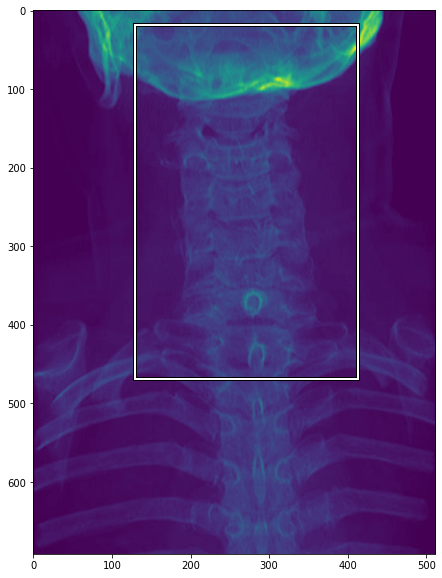

In [18]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    # bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return xmin_top_left, ymax_bottom_right, width, height

def draw_pascal_voc_bboxes(
        plot_ax,
        bbox,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    x, y, width, height = get_rectangle_corners_fn(bbox)

    rect_1 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=4,
        edgecolor="black",
        fill=False,
    )
    rect_2 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=2,
        edgecolor="white",
        fill=False,
    )

    # Add the patch to the Axes
    plot_ax.add_patch(rect_1)
    plot_ax.add_patch(rect_2)

def show_image(
        image, bbox=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10), ax=None
):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    if bbox is not None:
        draw_bboxes_fn(ax, bbox)
i = 20
image = Image.open(os.path.join(DATA_DIR, 'xray_images', df.iloc[i].UID, 'coronal.jpeg'))
bbox = df.iloc[i][['xmin','ymin','xmax','ymax']].values
show_image(image, bbox)